# Rețele Neurale Convoluționale - Cifar-100 

https://www.cs.toronto.edu/~kriz/cifar.html

## Termen de predare: 12 ianuarie 2024, ora 23:00

In [2]:
import torch 
from torch import nn, save, load
from torch.optim import Adam, AdamW, SGD
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train = datasets.CIFAR100(root="data", download=True, train=True, transform = transform)
train_dataset = DataLoader(train, batch_size=32, shuffle=True)

test = datasets.CIFAR100(root="data", download=True, train=False, transform=transform)
test_dataset = DataLoader(test,batch_size=32, shuffle=False)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,16,3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(64*2*2, 100)
        )
        
    def forward(self, x):
        return self.model(x)
    
    
Cifar100_classifier = ImageClassifier().to(device)
optimizer_adam = Adam(Cifar100_classifier.parameters(), lr = 0.0001)
optimizer_sgd = SGD(Cifar100_classifier.parameters(), lr=0.001)
optimizer_adamw = AdamW(Cifar100_classifier.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

summary(Cifar100_classifier, input_size=(3, 32, 32)) 

with open('initial_state.pt', 'wb') as f: 
    save(Cifar100_classifier.state_dict(), f) 

def test(model: nn.Module, loader: DataLoader, cm = False) -> float:
    if cm == True:
        y_true = []
        y_pred = []
    correctly_classified = 0
    total_items = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            pred = torch.argmax(model(x), dim=1)
            correctly_classified += (pred == y).sum().item()

            if cm == True:
                y_true.append(y.cpu().numpy().squeeze())  # Convert y tensor to CPU and then to NumPy array
                y_pred.append(pred.cpu().numpy().squeeze()) 
            total_items += len(x)
    accuracy = correctly_classified / total_items
    if cm:
        y_true = np.concatenate(y_true)  # Concatenate the list of arrays into a single array
        y_pred = np.concatenate(y_pred)  # Concatenate the list of arrays into a single array
        return accuracy, y_true, y_pred
    else:
        return accuracy
    
if __name__=="__main__":
    epochs = 50
    # Adam
    accuracy_train_Adam = []
    accuracy_test_Adam = []
    for epoch in range(epochs):
        Cifar100_classifier.train()
        for batch in train_dataset:
            x, y = batch
            x, y = x.to(device), y.to(device)
            yhat = Cifar100_classifier(x)
            loss = loss_function(yhat,y)
            
            #Backpropagation
            optimizer_adam.zero_grad()
            loss.backward()
            optimizer_adam.step()
            
        print(f"Epoch:{epoch} loss is {loss.item()}")

        accuracy_train_Adam.append(test(Cifar100_classifier, train_dataset))
        accuracy_test_Adam.append(test(Cifar100_classifier, test_dataset))
        
    #with open('model_state_cifrar100.pt', 'wb') as f: 
    #   save(Cifrar100_classifier.state_dict(), f) 
            
    print("Accuracy Adam is ", accuracy_test_Adam[-1])

    #with open('initial_state.pt', 'rb') as f: 
    #    Cifar100_classifier.load_state_dict(load(f))
        
    # SGD
    Cifar100_classifier.load_state_dict(torch.load('initial_state.pt'))
    accuracy_train_SGD = []
    accuracy_test_SGD = []
    for epoch in range(epochs):
        Cifar100_classifier.train()
        for batch in train_dataset:
            x, y = batch
            x, y = x.to(device), y.to(device)
            yhat = Cifar100_classifier(x)
            loss = loss_function(yhat,y)
            
            #Backpropagation
            optimizer_sgd.zero_grad()
            loss.backward()
            optimizer_sgd.step()
            
        print(f"Epoch:{epoch} loss is {loss.item()}")

        accuracy_train_SGD.append(test(Cifar100_classifier, train_dataset))
        accuracy_test_SGD.append(test(Cifar100_classifier, test_dataset))
        
    #with open('model_state_cifrar100.pt', 'wb') as f: 
    #   save(Cifrar100_classifier.state_dict(), f) 
            
    print("Accuracy SGD is ", accuracy_test_SGD[-1])
        
    # AdamW
    Cifar100_classifier.load_state_dict(torch.load('initial_state.pt'))
    accuracy_train_AdamW = []
    accuracy_test_AdamW = []
    for epoch in range(epochs):
        Cifar100_classifier.train()
        for batch in train_dataset:
            x, y = batch
            x, y = x.to(device), y.to(device)
            yhat = Cifar100_classifier(x)
            loss = loss_function(yhat,y)
            
            #Backpropagation
            optimizer_adamw.zero_grad()
            loss.backward()
            optimizer_adamw.step()
            
        print(f"Epoch:{epoch} loss is {loss.item()}")

        accuracy_train_AdamW.append(test(Cifar100_classifier, train_dataset))
        accuracy_test_AdamW.append(test(Cifar100_classifier, test_dataset))
            
    print("Accuracy AdamW is ", accuracy_test_AdamW[-1])

Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
         MaxPool2d-5             [-1, 32, 8, 8]               0
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
         MaxPool2d-8             [-1, 64, 4, 4]               0
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          36,928
        MaxPool2d-11             [-1, 64, 2, 2]               0
             ReLU-12             [-1, 64, 2, 2]               0
          Flatten-13       

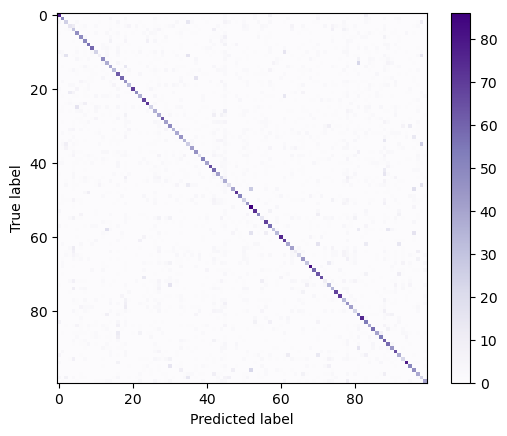

In [3]:
accuracy, y_true, y_pred = test(Cifar100_classifier,test_dataset, True)

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.show()

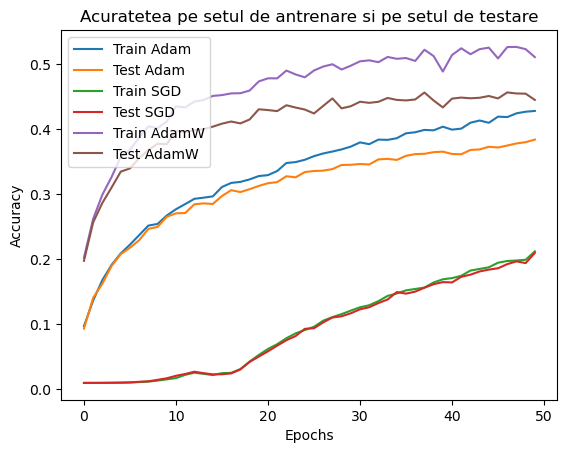

In [4]:
plt.plot(accuracy_train_Adam, label ="Train Adam")
plt.plot(accuracy_test_Adam, label ="Test Adam")
plt.plot(accuracy_train_SGD,  label ="Train SGD")
plt.plot(accuracy_test_SGD,  label ="Test SGD")
plt.plot(accuracy_train_AdamW, label ="Train AdamW")
plt.plot(accuracy_test_AdamW, label ="Test AdamW")
plt.title("Acuratetea pe setul de antrenare si pe setul de testare")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Suplimentar (opțional)
1. Utilizați [tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) pentru vizualizarea rezultatelor.
1. Matricea de confuzie ca procent + colorare heatmap.

<Figure size 20000x20000 with 0 Axes>

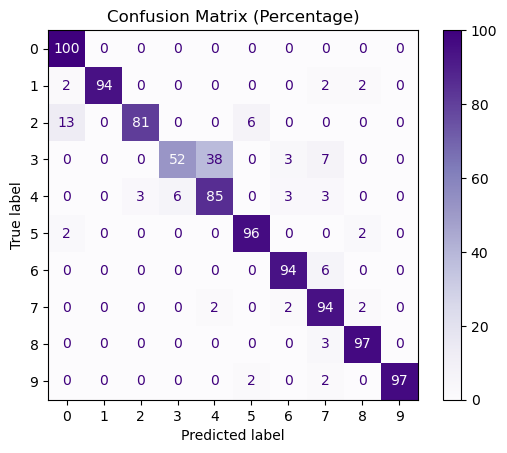

In [5]:
subset_classes = np.arange(10)
cm_subset = cm[subset_classes, :][:, subset_classes]

cm_normalized = cm_subset.astype('float') / cm_subset.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(200, 200))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap=plt.cm.Purples, values_format=".0f") 
plt.title('Confusion Matrix (Percentage)')
plt.show()